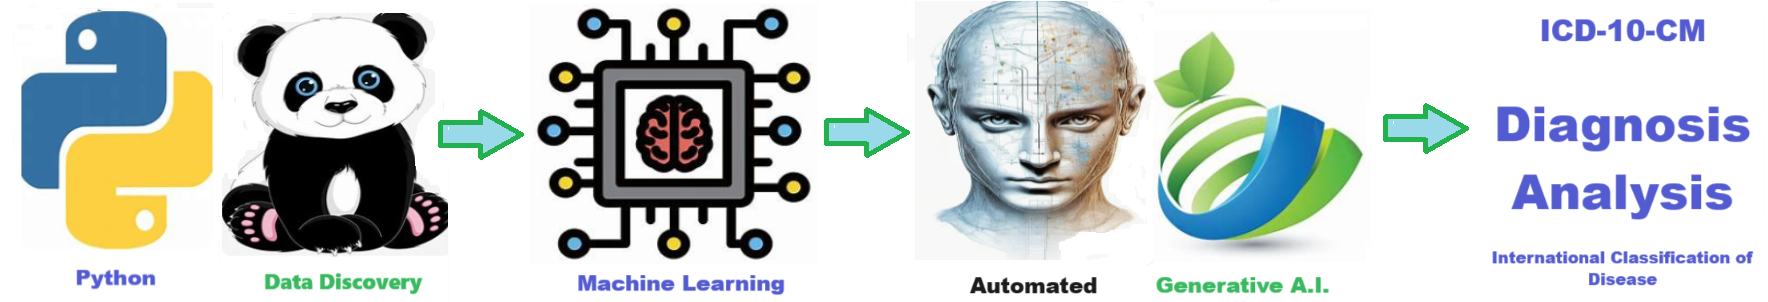


# International Classification of Disease - ICD-10-CM

## Explore and Analyze ICD-10-CM Diagnosis codeset

#### by Joe Eberle started on 05-23-2023 - https://github.com/JoeEberle/ - josepheberle@outlook.com

In [2]:
first_install = False 
if first_install:
    !pip install schedule
    !pip install zipp

In [3]:
import os
import schedule
from datetime import datetime
import pandas as pd 
import quick_logger as ql
import talking_code as tc 
import file_manager as fm 
import time
import zipfile
print(f"Libraries Imported succesfully on {datetime.now().date()} at {datetime.now().time()}") 

Libraries Imported succesfully on 2024-03-17 at 21:50:50.458365


## Optional Step 0 - Intitiate Configuration Settings and name the overall solution

In [4]:
import configparser 
config = configparser.ConfigParser()
cfg = config.read('config.ini')  

solution_name = 'icd_10_cm_analysis'

## Optional Step 0 - Intitiate Logging and debugging 

In [5]:
# Establish the Python Logger  
import logging # built in python library that does not need to be installed 
import quick_logger as ql

global start_stime 
start_time = ql.set_start_time()
logging = ql.create_logger_start(solution_name, start_time) 
ql.set_speaking_log(False)
ql.set_speaking_steps(False)
ql.pvlog('info',f'Process {solution_name} Step 0 - Initializing and starting Logging Process.') 

Process icd_10_cm_analysis Step 0 - Initializing and starting Logging Process.


In [9]:
import pandas as pd

# Using double backslashes
df_icd_10_cm = pd.read_csv("C:\\Users\\josep\\datasets\\icdcodeset.csv")

print(df_icd_10_cm.shape)
df_icd_10_cm.head()

(73639, 2)


,ICDCode,Description
0,A000,"Cholera due to Vibrio cholerae 01, biovar c..."
1,A001,"Cholera due to Vibrio cholerae 01, biovar e..."
2,A009,"Cholera, unspecified"
3,A0100,"Typhoid fever, unspecified"
4,A0101,Typhoid meningitis


In [11]:
def get_codes_between(df, start_code, end_code):
    start_index = df.index[df['ICDCode'] == start_code].tolist()
    end_index = df.index[df['ICDCode'] == end_code].tolist()
    
    if not start_index:
        print(f"Start code {start_code} not found.")
        return pd.DataFrame()
    elif not end_index:
        print(f"End code {end_code} not found.")
        return pd.DataFrame()
    else:
        start_index = start_index[0]
        end_index = end_index[0]
        return df.iloc[start_index:end_index + 1]

# Example usage:
start_code = 'A02'
end_code = 'A06'
codes_between = get_codes_between(df_icd_10_cm, start_code, end_code)
print(codes_between)


Start code A02 not found.
Empty DataFrame
Columns: []
Index: []


In [34]:
def get_codes_between(df, start_code, end_code):
    start_index = df[df['ICDCode'].str.startswith(start_code)].index.tolist()
    end_index = df[df['ICDCode'].str.startswith(end_code)].index.tolist()
    
    if not start_index:
        print(f"No codes found starting with {start_code}.")
        return pd.DataFrame()
    elif not end_index:
        print(f"No codes found starting with {end_code}.")
        return pd.DataFrame()
    else:
        start_index = start_index[0]
        end_index = end_index[-1]  # Get the last index matching end_code
        return df.iloc[start_index:end_index + 1]

# Example usage:

 # Neoplasms (C00-D49)
start_code = 'C00'
end_code = 'D49'
df_diagnosis_code_subset = get_codes_between(df_icd_10_cm, start_code, end_code)
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)     # Show all rows
for index, row in df_diagnosis_code_subset.iterrows():
    icd10_code = row['ICDCode']
    description = row['Description']
    print(f"Code: {icd10_code}-{description}")
 

Code: C000-   Malignant neoplasm of external upper lip
Code: C001-   Malignant neoplasm of external lower lip
Code: C002-   Malignant neoplasm of external lip, unspecified
Code: C003-   Malignant neoplasm of upper lip, inner aspect
Code: C004-   Malignant neoplasm of lower lip, inner aspect
Code: C005-   Malignant neoplasm of lip, unspecified, inner aspect
Code: C006-   Malignant neoplasm of commissure of lip, unspecified
Code: C008-   Malignant neoplasm of overlapping sites of lip
Code: C009-   Malignant neoplasm of lip, unspecified
Code: C01-    Malignant neoplasm of base of tongue
Code: C020-   Malignant neoplasm of dorsal surface of tongue
Code: C021-   Malignant neoplasm of border of tongue
Code: C022-   Malignant neoplasm of ventral surface of tongue
Code: C023-   Malignant neoplasm of anterior two-thirds of tongue, part unspecified
Code: C024-   Malignant neoplasm of lingual tonsil
Code: C028-   Malignant neoplasm of overlapping sites of tongue
Code: C029-   Malignant neoplasm o

In [36]:
def assign_diagnosis_class(row, low_code, upper_code):
    icd_code = row['ICDCode']
    if icd_code.startswith('C') and low_code <= icd_code <= upper_code:
        return "Malignant Neoplasm"
    else:
        return None

def enhance_dataframe(df, low_code, upper_code):
    df['diagnosis_class'] = df.apply(assign_diagnosis_class, args=(low_code, upper_code), axis=1)
    return df

low_code = 'C00'
upper_code = 'C49'

enhanced_df = enhance_dataframe(df_icd_10_cm, low_code, upper_code)
enhanced_df.head(10) 


,ICDCode,Description,diagnosis_class
0,A000,"Cholera due to Vibrio cholerae 01, biovar c...",None
1,A001,"Cholera due to Vibrio cholerae 01, biovar e...",None
2,A009,"Cholera, unspecified",None
3,A0100,"Typhoid fever, unspecified",None
4,A0101,Typhoid meningitis,None
5,A0102,Typhoid fever with heart involvement,None
6,A0103,Typhoid pneumonia,None
7,A0104,Typhoid arthritis,None
8,A0105,Typhoid osteomyelitis,None
9,A0109,Typhoid fever with other complications,None


In [26]:
def search_icd_description(df, search_word):
    ''' Filter rows where the 'Description' column contains the search word (case-insensitive) '''
    filtered_df = df[df['Description'].str.contains(search_word, case=False)]
    return filtered_df

# Example usage:
search_word = 'diabetes'
df_diagnosis_subset = search_icd_description(df_icd_10_cm, search_word)
print(f"found {df_diagnosis_subset.shape[0]}  diagnosis codes containing {search_word} ")

search_word = 'pathology'
df_diagnosis_subset = search_icd_description(df_icd_10_cm, search_word)
print(f"found {df_diagnosis_subset.shape[0]}  diagnosis codes containing {search_word} ")

search_word = 'birth weight'
df_diagnosis_subset = search_icd_description(df_icd_10_cm, search_word)
print(f"found {df_diagnosis_subset.shape[0]}  diagnosis codes containing {search_word} ")

search_word = 'neoplasm'
df_diagnosis_subset = search_icd_description(df_icd_10_cm, search_word)
print(f"found {df_diagnosis_subset.shape[0]}  diagnosis codes containing {search_word} ")
df_diagnosis_subset.head()

found 478  diagnosis codes containing diabetes 
found 1  diagnosis codes containing pathology 
found 10  diagnosis codes containing birth weight 
found 960  diagnosis codes containing neoplasm 


,ICDCode,Description
1065,C000,Malignant neoplasm of external upper lip
1066,C001,Malignant neoplasm of external lower lip
1067,C002,"Malignant neoplasm of external lip, unspeci..."
1068,C003,"Malignant neoplasm of upper lip, inner aspect"
1069,C004,"Malignant neoplasm of lower lip, inner aspect"


In [24]:
def search_icd_codes(df, search_word):
    ''' Filter rows where the 'ICDCode' column contains the search word (case-insensitive) '''
    filtered_df = df[df['ICDCode'].str.contains(search_word, case=False)]
    return filtered_df

# Example usage:
search_word = 'E080'
df_diagnosis_subset = search_icd_codes(df_icd_10_cm, search_word)
print(f"found {df_diagnosis_subset.shape[0]}  diagnosis codes containing {search_word} ")
df_diagnosis_subset.head()

found 2  diagnosis codes containing E080 


,ICDCode,Description
3089,E0800,Diabetes mellitus due to underlying conditio...
3090,E0801,Diabetes mellitus due to underlying conditio...


## Step 0 - Process End - display log

In [6]:
# Calculate and classify the process performance 
status = ql.calculate_process_performance(solution_name, start_time) 
print(ql.append_log_file(solution_name))  

2024-03-17 21:50:59,171 - INFO - START icd_10_cm_analysis =============================================
2024-03-17 21:50:59,171 - INFO - START icd_10_cm_analysis Start Time = 2024-03-17 21:50:59
2024-03-17 21:50:59,171 - INFO - icd_10_cm_analysis Step 0 - Initialize the configuration file parser
2024-03-17 21:50:59,172 - INFO - Process icd_10_cm_analysis Step 0 - Initializing and starting Logging Process.
2024-03-17 21:51:05,577 - INFO - PERFORMANCE icd_10_cm_analysis The total process duration was:6.41
2024-03-17 21:51:05,577 - INFO - PERFORMANCE icd_10_cm_analysis Stop Time = 2024-03-17 21:51:05
2024-03-17 21:51:05,587 - INFO - PERFORMANCE icd_10_cm_analysis Low process duration less than 3 minutes:6.41
2024-03-17 21:51:05,587 - INFO - PERFORMANCE icd_10_cm_analysis Performance optimization is optional
2024-03-17 21:51:05,587 - INFO - END icd_10_cm_analysis =============================================



#### https://github.com/JoeEberle/ -- josepheberle@outlook.com